In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
cd drive/My\ Drive

/content/drive/My Drive


In [4]:
cd zindi

/content/drive/My Drive/zindi


In [ ]:
from fastai import *
from fastai.imports import *
from fastai.vision import *

In [ ]:
from pathlib import Path
import pandas as pd

In [ ]:
path = Path(".")

In [8]:
path.ls()

[PosixPath('test.zip'),
 PosixPath('train.zip'),
 PosixPath('train'),
 PosixPath('test'),
 PosixPath('models'),
 PosixPath('subres152.csv'),
 PosixPath('subres50_224.csv')]

In [ ]:
bs = 32

In [ ]:
tfms = get_transforms(flip_vert=True, max_lighting=0.4, xtra_tfms=[*zoom_crop(scale=(0.75,1), do_rand=True)])

In [ ]:
data = ImageDataBunch.from_folder(path, train="train", test='test', valid_pct=0.1,
        ds_tfms=tfms, size=224, num_workers=4, bs=bs).normalize(imagenet_stats)

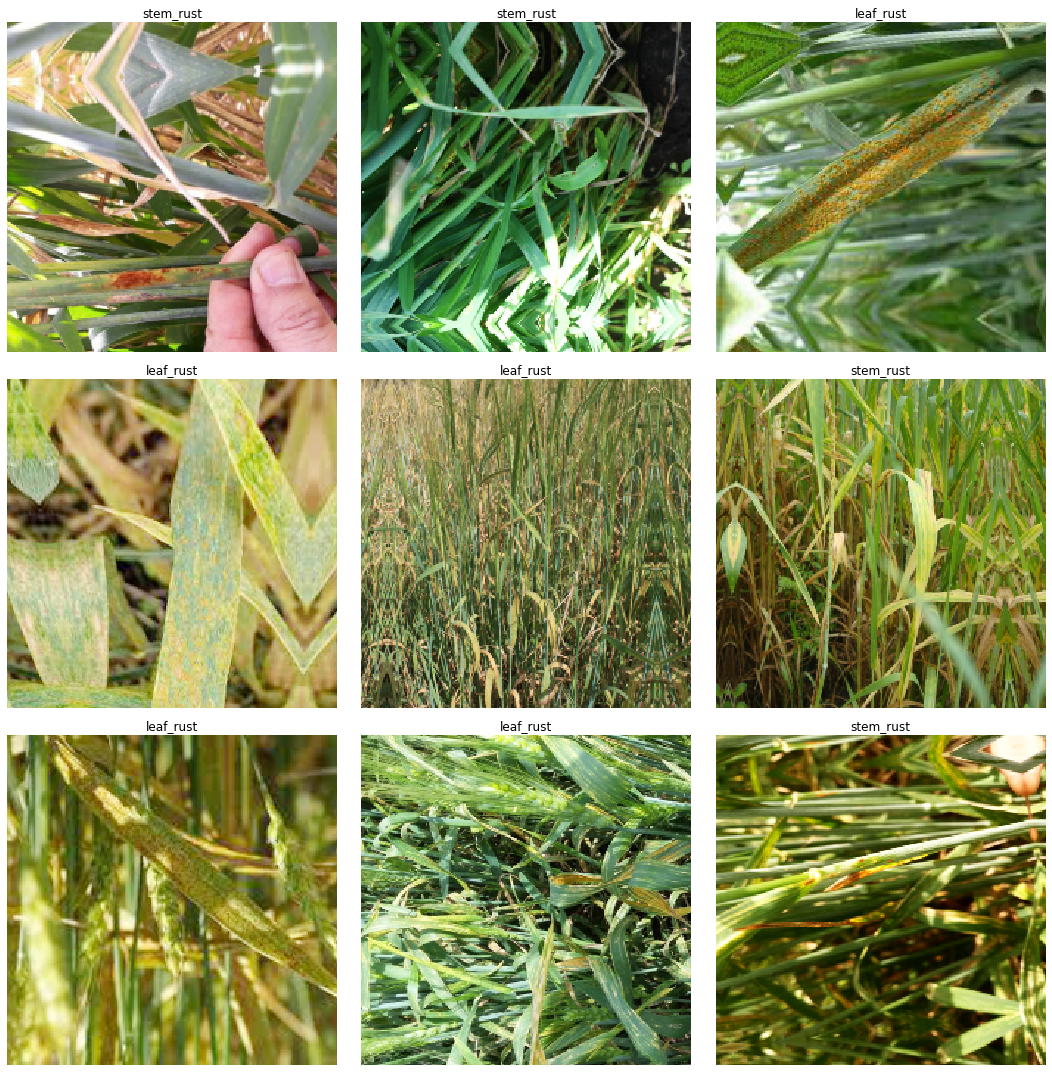

In [12]:
data.show_batch(rows=3, figsize=(15, 15))

In [13]:
data.classes

['healthy_wheat', 'leaf_rust', 'stem_rust']

In [ ]:
class Log_loss(Callback):

  def on_epoch_begin(self, **kwargs):
    self.count, self.val = 0., 0.

  def on_batch_end(self, last_output, last_target, **kwargs):
        if not is_listy(last_target): last_target=[last_target]
        self.count += last_target[0].size(0)
        loss = F.cross_entropy(last_output, *last_target)
        
        self.val += last_target[0].size(0) * loss.detach().cpu()

  def on_epoch_end(self, last_metrics, **kwargs):
    "Set the final result in `last_metrics`."
    return add_metrics(last_metrics, self.val/self.count)

In [15]:
learn = cnn_learner(data, models.densenet201, metrics=[error_rate, accuracy,Log_loss()]).mixup()

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/checkpoints/densenet201-c1103571.pth


In [21]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


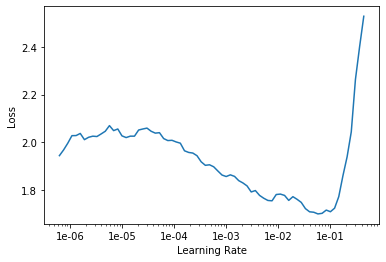

In [22]:
learn.lr_find()
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(40, max_lr=slice(1e-3,1e-2))

epoch,train_loss,valid_loss,error_rate,accuracy,log_loss,time
0,1.533250,0.687424,0.264368,0.735632,0.687424,03:00
1,1.474110,0.618970,0.229885,0.770115,0.618970,02:06
2,1.377916,0.517143,0.218391,0.781609,0.517143,02:08
3,1.266491,0.475744,0.183908,0.816092,0.475744,02:08
4,1.119957,0.536629,0.195402,0.804598,0.536629,02:06
5,0.986912,0.610785,0.229885,0.770115,0.610785,02:08
6,0.897717,0.405893,0.126437,0.873563,0.405893,02:07
7,0.822614,0.393327,0.137931,0.862069,0.393327,02:08
8,0.794615,0.503363,0.195402,0.804598,0.503363,02:09
9,0.800084,0.849294,0.206897,0.793103,0.849294,02:10


In [ ]:
learn.save("stage1")

In [ ]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


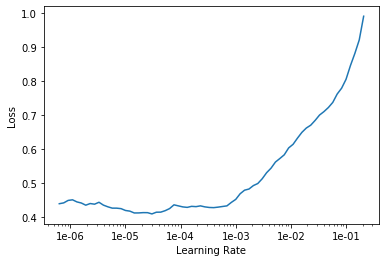

In [19]:
learn.lr_find()
learn.recorder.plot()

In [20]:
# learn.fit_one_cycle(5, max_lr=slice(1e-5,1e-4))
learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,error_rate,accuracy,log_loss,time
0,0.404360,0.248274,0.103448,0.896552,0.248274,02:08
1,0.405881,0.237445,0.091954,0.908046,0.237445,02:09
2,0.412257,0.236446,0.091954,0.908046,0.236446,02:09
3,0.418636,0.250406,0.091954,0.908046,0.250406,02:10
4,0.414664,0.237147,0.091954,0.908046,0.237147,02:09
5,0.411474,0.243116,0.091954,0.908046,0.243116,02:12
6,0.405736,0.249433,0.091954,0.908046,0.249433,02:12
7,0.401765,0.238258,0.091954,0.908046,0.238258,02:13
8,0.410494,0.234844,0.091954,0.908046,0.234844,02:11
9,0.408696,0.236787,0.091954,0.908046,0.236787,02:11


In [21]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

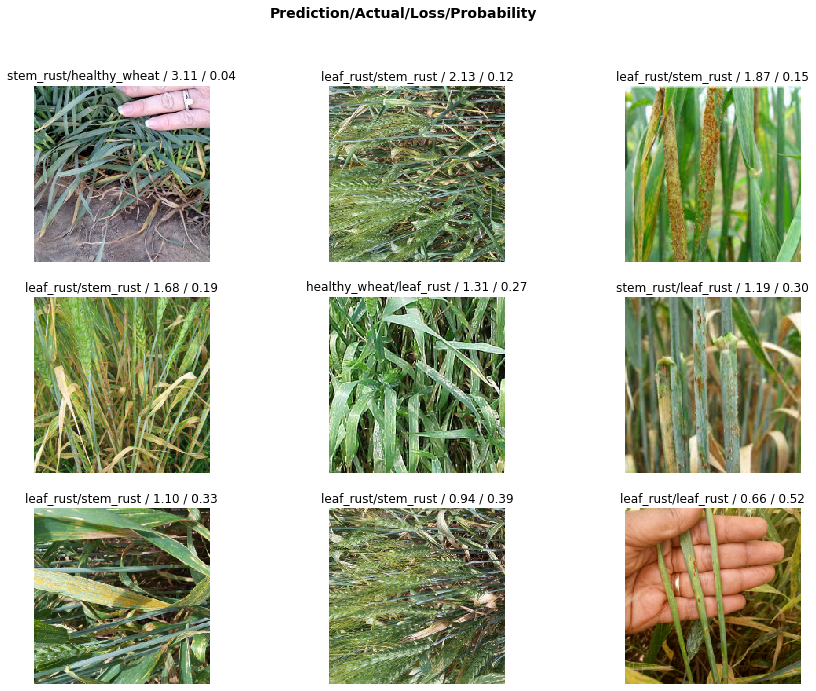

In [22]:
interp.plot_top_losses(9, figsize=(15,11))

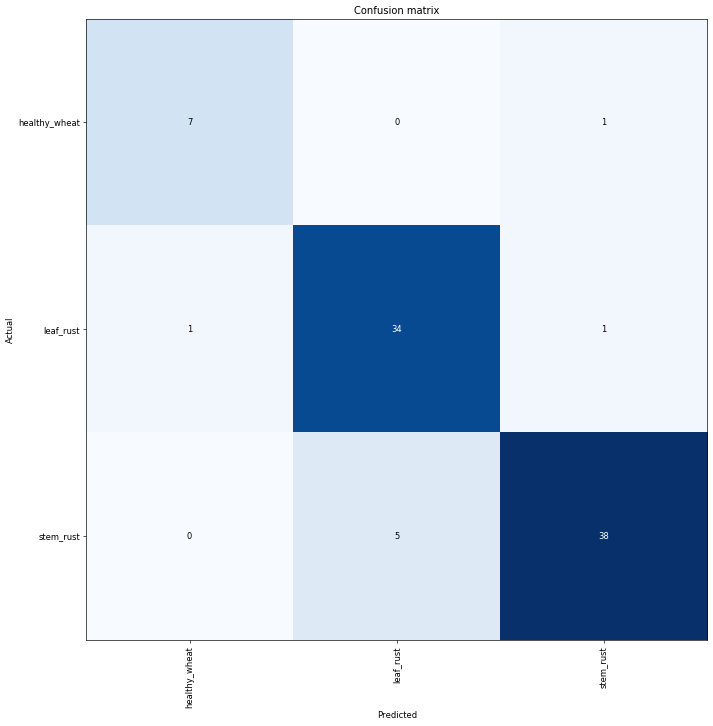

In [23]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [24]:
interp.most_confused(min_val=2)

[('stem_rust', 'leaf_rust', 5)]

In [ ]:
learn.export()

In [26]:
preds, y = learn.get_preds(DatasetType.Test)

In [ ]:
npred = to_np(preds)

TTA


In [30]:
tta_pred = learn.TTA(ds_type=DatasetType.Test)

In [ ]:
tta_pred = learn.TTA(ds_type=DatasetType.Test,scale=2)

In [34]:
tta_pred = learn.TTA(ds_type=DatasetType.Test,scale=1.0)

In [ ]:
tta_pred = learn.TTA(ds_type=DatasetType.Test,scale=0.65)

In [ ]:
n_tpred = to_np(tta_pred[0])

In [ ]:
n_tpred.shape

(610, 3)

In [28]:
import os
submission = pd.DataFrame({'ID': [s.name.split('.')[0] for s in (path/"test").ls() ]})
for i, c in enumerate(learn.data.classes):
  submission[c] = npred[:,i]
submission = submission[['ID', 'leaf_rust', 'stem_rust', 'healthy_wheat']] # Get same order as sample sub
submission.head()

,ID,leaf_rust,stem_rust,healthy_wheat
0,EK02MQ,0.033901,0.958229,0.007870
1,ROPN18,0.172687,0.824717,0.002595
2,BN5L96,0.011054,0.984739,0.004207
3,7AJUBC,0.063720,0.093974,0.842307
4,1R1HEY,0.026829,0.972914,0.000257


In [36]:
import os
submission = pd.DataFrame({'ID': [s.name.split('.')[0] for s in (path/"test").ls() ]})
for i, c in enumerate(learn.data.classes):
  submission[c] = n_tpred[:,i]
submission = submission[['ID', 'leaf_rust', 'stem_rust', 'healthy_wheat']] # Get same order as sample sub
submission.head()

,ID,leaf_rust,stem_rust,healthy_wheat
0,EK02MQ,0.125846,0.859063,0.015091
1,ROPN18,0.115556,0.881143,0.003301
2,BN5L96,0.019431,0.976708,0.003861
3,7AJUBC,0.055076,0.112739,0.832184
4,1R1HEY,0.033418,0.966248,0.000334


In [ ]:
submission.to_csv("subresd201_tta.csv",index=False)

In [ ]:
learn.data.c

3

In [19]:
learn = None
gc.collect()

27335